# Исследование условий успеха видеоигры

## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных
- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Откроем файл с данными и изучим общую информацию

In [2]:
try:
     games = pd.read_csv('/datasets/games.csv')
except:
     games = pd.read_csv('c:/Users/User/Downloads/games.csv')
games.info()
games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
games.duplicated().sum()

0

- Данные загружены и готовы к предобработке.

## 2. Подготовка данных

#### 2.1 Заменим названия столбцов (приведём к нижнему регистру)

In [4]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

- Проверим наличие неявных дубликатов.

In [5]:
games[games[['name', 'platform','year_of_release']].duplicated(keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


In [6]:
games = games.drop(index= 16230)

#### 2.2 Обработка пропусков

- В столбце `name` имеются пропуски. Эти строчки придется удалить.

In [7]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [8]:
games = games.dropna(subset=['name']).reset_index(drop=True)

- Пропуски в остальных столбцах мы заменять не будем, чтобы не искажать данные. Строки с пропущенным годом релиза удалим, их 269 штук (около 1.6% от всего объема данных)

In [9]:
games = games.dropna(subset=['year_of_release']).reset_index(drop=True)

- В столбце `user_score` кроме числовых значений и NaN есть и другие значения:

In [10]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

- Аббревиатура `tbd` означает `to be defined` - предстоит определить, то есть на данный момент это пропуск в данных. Заменим на их на `NaN`.

In [11]:
games[games['user_score'] == 'tbd']['user_score'].count()

2376

In [12]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = float('nan')

- Пропуски в рейтинге `ESRB` заменим на аббревиатуру `ND` - не определен. Устаревшую аббревиатуру `K-A` заменим на современное обозначение `E`.

In [13]:
games['rating'] = games['rating'].fillna(value='ND')
games['rating'] = games['rating'].replace('K-A', 'E')

- Пропуски в столбцах рейтингов критиков и пользователей оставим без изменений. Они связаны, вероятно, с тем, что не каждая игра удостаивалась внимания критиков или доходила до широких международных рынков, а также с региональными особенностями.

#### 2.3 Преобразуем данные в нужные типы.

- Тип данных в столбце `year_of_release` нужно заменить на `int64`.   
- Тип данных в столбце `user_score` нужно заменить на `float`.

In [14]:
games['year_of_release'] = games['year_of_release'].astype(int)
games['user_score'] = games['user_score'].astype(float)

#### 2.4 Посчитаем суммарные продажи во всех регионах и запишем их в отдельный столбец.

In [15]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,ND,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,ND,31.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,ND,0.01
16439,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,ND,0.01
16440,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,ND,0.01
16441,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,ND,0.01


In [16]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16443 entries, 0 to 16442
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  int32  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: float64(7), int32(1), object(4)
memory usage: 1.4+ MB


### Вывод
- В процессе подготовки данных, привели имена столбцов к нижнему регистру, привели данные в двух столбцах к целочисленному типу и избавились от записей с критичными пропусками в данных - названием и годом выпуска, а также добавили новый столбец - подсчитали суммарный объем продаж во всех регионах. Всего из 16715 строк осталось 16444.

## 3. Исследовательский анализ данных

#### 3.1 Сколько игр выпускалось в разные годы

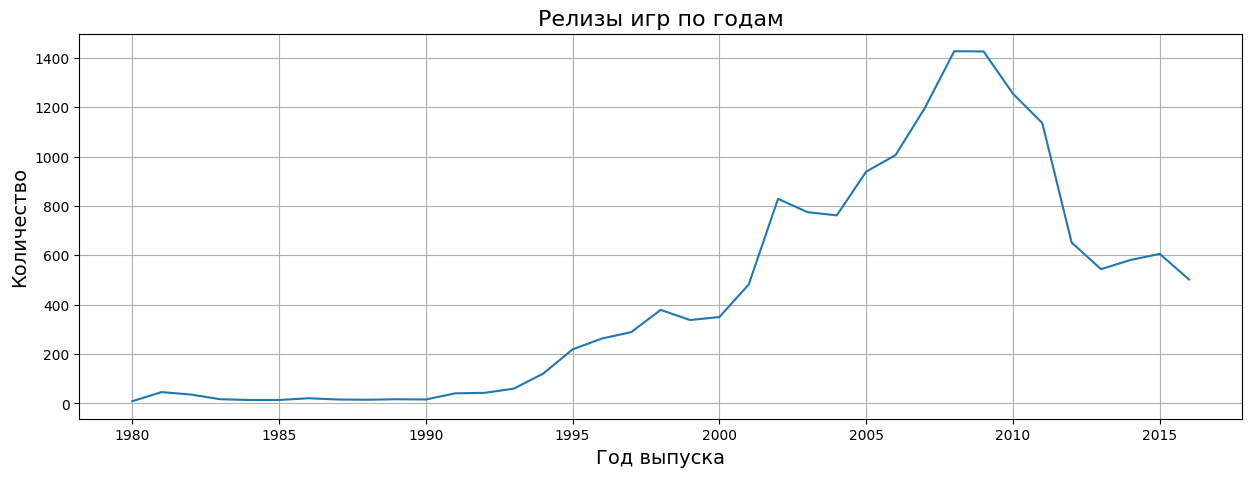

In [17]:
plt.figure(figsize=(15,5))
plt.plot(games.groupby('year_of_release')['name'].count(), label='Релизы')
plt.title("Релизы игр по годам", fontsize=16)
plt.xlabel('Год выпуска', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.grid()
plt.show()

In [18]:
games.groupby('year_of_release')['name'].count().sort_values(ascending=False).head(10)

year_of_release
2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
Name: name, dtype: int64

In [19]:
games.groupby('year_of_release')['name'].count().sort_values(ascending=False).tail(16)

year_of_release
1995    219
1994    121
1993     60
1981     46
1992     43
1991     41
1982     36
1986     21
1989     17
1983     17
1990     16
1987     16
1988     15
1985     14
1984     14
1980      9
Name: name, dtype: int64

In [20]:
games_94 = games[games['year_of_release'] > 1993]
games_94

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,ND,31.38
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
...,...,...,...,...,...,...,...,...,...,...,...,...
16438,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,ND,0.01
16439,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,ND,0.01
16440,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,ND,0.01
16441,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,ND,0.01


- Создана новая таблица так как до 1994 года количество релизов в год не превышало 100, и эти данные сложно назвать актуальными. Взлет начинается в 1994 году, возможно, с удешевлением гаджетов и их повсеместным распространением.
- В 2000-х годах наступает настоящий расцвет видеоигр, и количество релизов достигает максимума - более чем 1400 в 2008-2009 годах. 

#### 3.2 Как менялись продажи по платформам

- Посмотрим, как выходили  игры на разных платформах. Создадим сводную таблицу и отфильтруем те платформы, на которых вышло хотя бы 50 игр.  Подсветим таблицу так, чтобы увидеть таймлайны разных платформ.

In [21]:
platform_sales = games_94.pivot_table(index='platform', 
                                      values='total_sales', 
                                      columns = 'year_of_release', 
                                      aggfunc = 'sum', 
                                      fill_value=0, 
                                      margins=True).reset_index()
platform_sales = platform_sales[:-1]
platform_sales = platform_sales.rename_axis('index',  axis="columns")

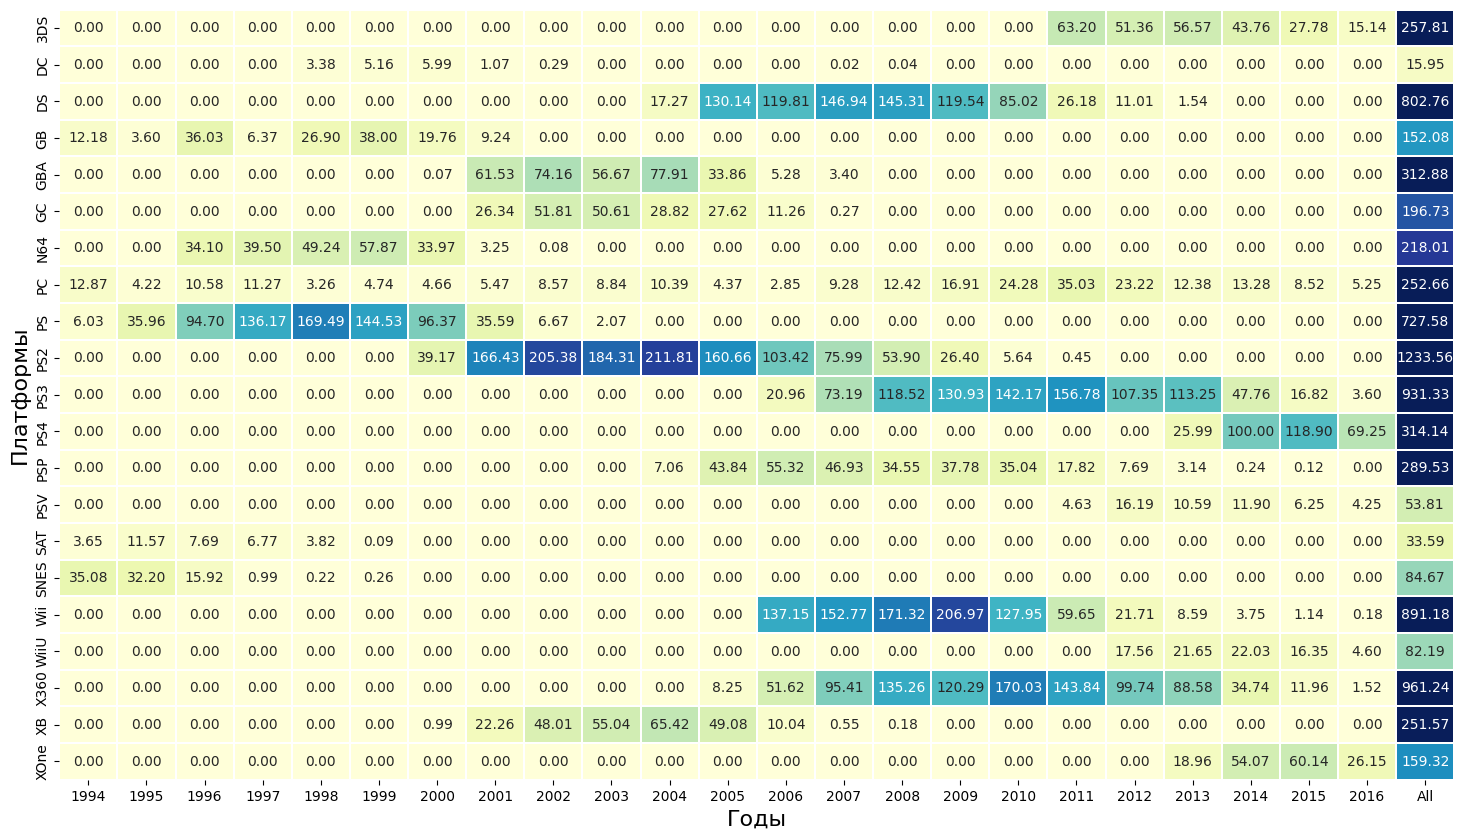

In [22]:
platform_sales_heatmap = platform_sales.query('All > 10').set_index('platform')
plt.figure(figsize=(18, 10))
sns.heatmap(platform_sales_heatmap, annot=True, fmt=".2f", cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.xlabel('Годы', fontsize=16)
plt.ylabel('Платформы', fontsize=16)
plt.show()

In [23]:
life_time = games.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()

life_time = life_time.set_axis(['platform', 'first_year', 'last_year'], axis='columns')

life_time['length'] = life_time.last_year - life_time.first_year + 1
life_time['length'].describe()


count    31.000000
mean      8.612903
std       6.998464
min       1.000000
25%       4.000000
50%       7.000000
75%      11.000000
max      32.000000
Name: length, dtype: float64

In [24]:
life_time[life_time['length'] == 32]

,platform,first_year,last_year,length
13,PC,1985,2016,32


- Видим, что платформы в среднем "живут" примерно 7-8 лет, пик популярности приходится на середину этого срока. Естественно `PC` "живёт" постоянно.

#### 3.3 Определим актуальные платформы.

- Актуальным периодом будем считать данные с 2013 года.

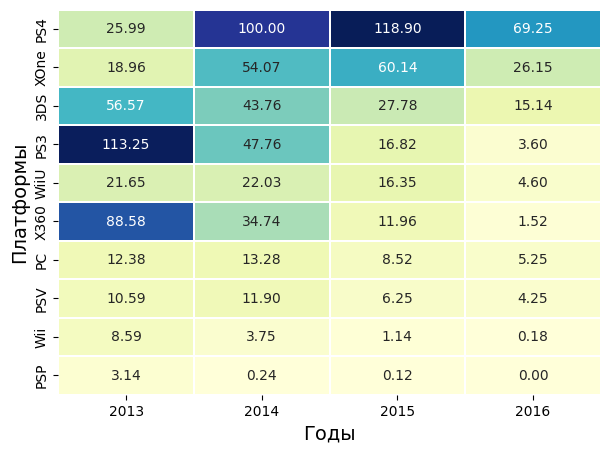

In [25]:
platform_sales_heatmap = platform_sales.sort_values(by=2015, ascending=False)[['platform', 2013, 2014, 2015, 2016]].head(10).set_index('platform')

plt.figure(figsize=(7, 5))
sns.heatmap(platform_sales_heatmap, annot=True, fmt=".2f", cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.xlabel('Годы', fontsize=14)
plt.ylabel('Платформы', fontsize=14)
plt.show()

- Для дальнейшего анализа оставим наиболее перспективные платформы - PlayStation 4, WiiU, XBox One и PC, а также еще не лишенную потенциала Nintendo 3DS.

In [26]:
games_actual = games.query('platform in ["PS4", "WiiU", "XOne", "PC", "3DS"] and year_of_release > 2012') 

In [27]:
actual_platforms = ["PS4", "WiiU", "XOne", "PC", "3DS"]
games_actual = games.query('year_of_release > 2012') 

#### 3.3 Определим какие платформы лидируют по продажам.

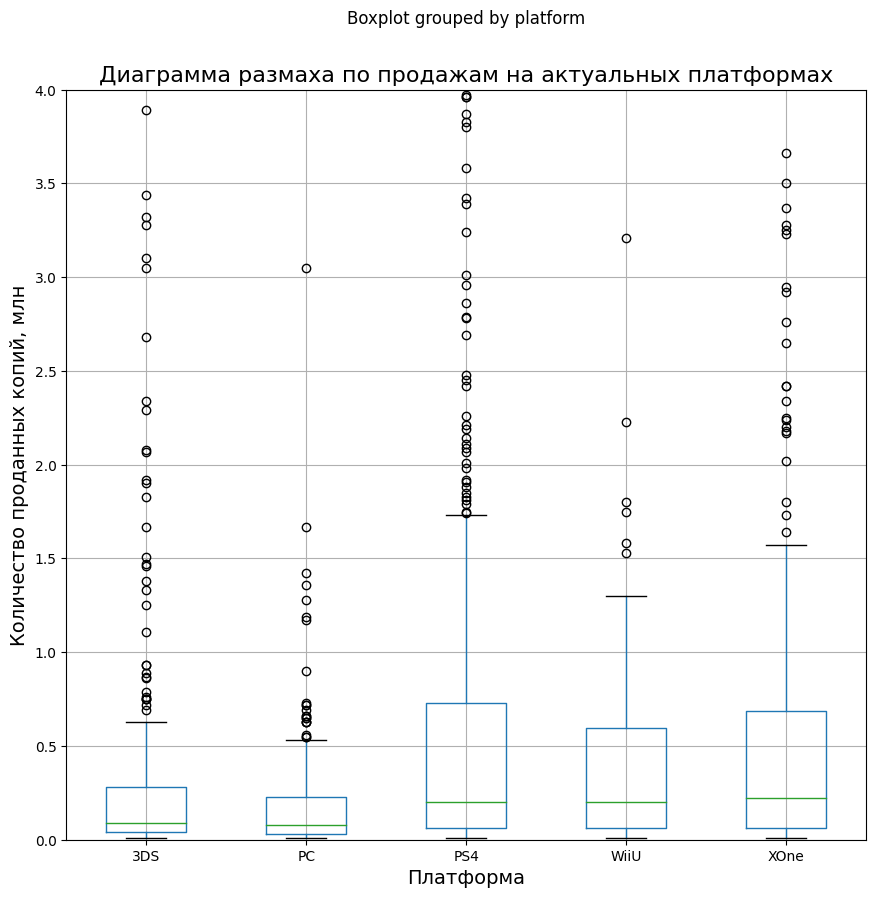

In [28]:
(games_actual.query('platform in @actual_platforms')[['platform', 'name', 'total_sales']]
 .boxplot(column='total_sales', by='platform', figsize=(10,10))
)
plt.xlabel('Платформа', fontsize=14)
plt.ylabel('Количество проданных копий, млн', fontsize=14)
plt.title('Диаграмма размаха по продажам на актуальных платформах', fontsize=16)
plt.ylim(0, 4)
plt.show()

In [29]:
games_actual.query('platform in @actual_platforms')\
            .pivot_table(index='platform', values='total_sales', aggfunc=['sum', 'mean', 'median', 'std', 'count'])\
            .sort_values(('median', 'total_sales'), ascending=False)

,sum,mean,median,std,count
,total_sales,total_sales,total_sales,total_sales,total_sales
platform,,,,,
XOne,159.32,0.645020,0.22,1.036139,247
PS4,314.14,0.801378,0.20,1.609456,392
WiiU,64.63,0.562000,0.20,1.038778,115
3DS,143.25,0.472772,0.09,1.381347,303
PC,39.43,0.208624,0.08,0.352304,189


- Лидером продаж является PlayStation 4, но и размах продаж по годам у нее самый большой. 
- ПК является самой непопулярной платформой, но и самой стабильной - размах самый узкий. Среднее число продаж игр для десктопов самое низкое и доля бестселлеров самая маленькая. 
- Медианные продажи по каждой из платформ заметно меньше 1 млн, но выбросы показывают, что у каждой из платформ случаются супер-хиты, приносящие миллионы - доля таких успешных проектов выше всего у PlayStation 4 и XBox one - это видно и по большему среднему значению числа продаж.    
- Выбросы на боксплотах - это какие-то суперопулярные игры. Сравним 3DS и XOne. У первого маленький ящик и много выбросов. Это говорит о том, что большая часть объема продаж делается за счет этих выбросов. В то же время у XOne ситуация иная: большой бокс, длинный ус и мало выбросов. Это свидетельствует о том, что на XOne покупают самые разные игры, причем, в немалом количестве.

#### 3.4 Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. 

- Для примера выберем одну из популярных платформ - PS4.

In [30]:
games_select = games_actual.query('platform == "PS4"')

print(f'Корреляция между оценкой критиков и продажами: {games_select.critic_score.corr(games_select.total_sales):.2}')
print(f'Корреляция между оценкой пользователей и продажами: {games_select.user_score.corr(games_select.total_sales):.2}')
print(f'Корреляция между оценками критиков и пользователей: {games_select.critic_score.corr(games_select.user_score):.2}')

Корреляция между оценкой критиков и продажами: 0.41
Корреляция между оценкой пользователей и продажами: -0.032
Корреляция между оценками критиков и пользователей: 0.56


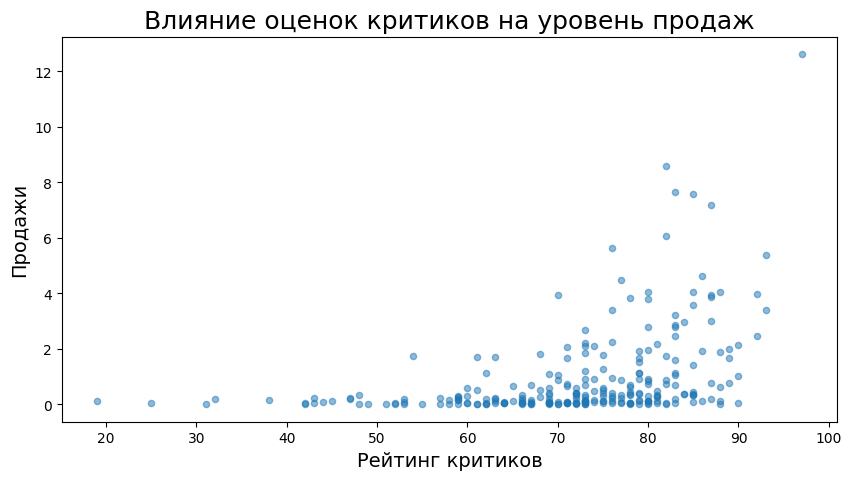

In [31]:
games_select.plot.scatter('critic_score',  'total_sales', figsize=(10, 5), alpha=0.5)
plt.xlabel('Рейтинг критиков', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.title('Влияние оценок критиков на уровень продаж', fontsize=18)
plt.show()

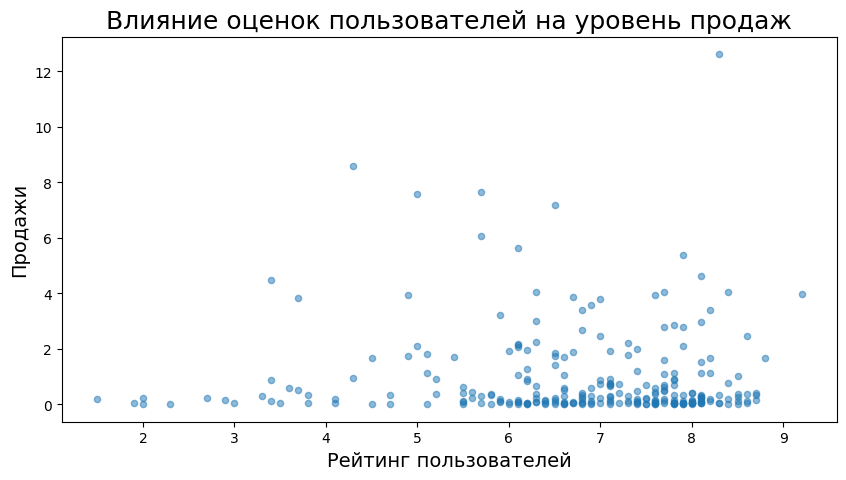

In [32]:
games_select.plot.scatter('user_score', 'total_sales', figsize=(10, 5), alpha=0.5)
plt.xlabel('Рейтинг пользователей', fontsize=14)
plt.ylabel('Продажи', fontsize=14)
plt.title('Влияние оценок пользователей на уровень продаж', fontsize=18)
plt.show()

- В целом распределение ожидаемое, хотя и не линейное - чем выше оценка критиков, тем выше продажи, линейная корреляция сильнее между оценками критиков и продажами, а между продажами и оценками пользователей корреляция не только слабая, но и обратная. Заметно также, что игры с высоким рейтингом у критиков зачастую имеют средние оценки пользователей - и корреляция между оценками средняя. В целом, при прогнозе продаж немного надежнее полагаться на отзывы критиков.

#### 3.5 Соотнесём выводы с продажами игр на всех актуальных платформах.

C:\Users\User\AppData\Local\Temp\ipykernel_9964\998640372.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data, ax=ax)


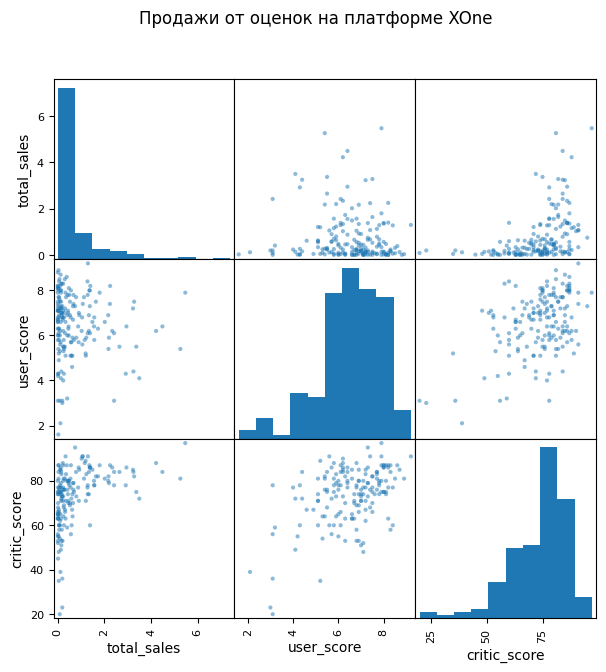

C:\Users\User\AppData\Local\Temp\ipykernel_9964\998640372.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data, ax=ax)


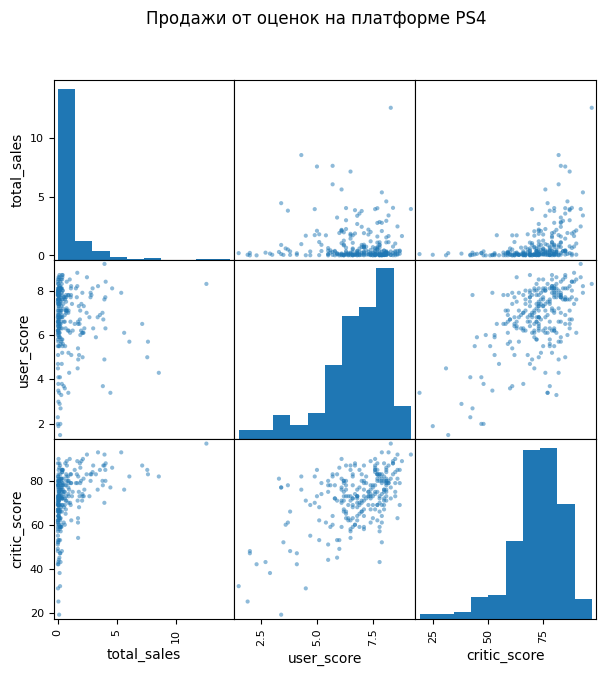

In [ ]:
for p in ["XOne", "PS4", "WiiU", "3DS", "PC"]:
    data = games.query('platform == @p')[['total_sales','user_score', 'critic_score']]
  
    fig, ax = plt.subplots(figsize = (7,7))
    pd.plotting.scatter_matrix(data, ax=ax)
    fig.suptitle(f'Продажи от оценок на платформе {p}')
    plt.show()

In [ ]:
for p in ["XOne", "PS4", "WiiU", "3DS", "PC"]:
    print(p)
    games_select = games.query('platform == @p')
    print(f'Корреляция между оценкой критиков и продажами: {games_select.critic_score.corr(games_select.total_sales):.2}')
    print(f'Корреляция между оценкой пользователей и продажами: {games_select.user_score.corr(games_select.total_sales):.2}')
    print(f'Корреляция между оценками критиков и пользователей: {games_select.critic_score.corr(games_select.user_score):.2}')
    print('--' * 30)

- Значения корреляций отличаются, но общий тренд есть. Оценка критиков немного сильнее коррелирует с продажами, хотя эта связь и не является сильной. Корреляция оценок пользователей и продаж совсем слабая. Возможно, это связано и с тем, что далеко не все пользователи пишут отзывы и оставляют оценки.
- О связи оценок и продаж трудно говорить и потому, что некоторые игры поставляются эксклюзивно только на одной платформе.

#### 3.6 Посмотрим на общее распределение игр по жанрам. 

In [ ]:
genre_sales = games_actual.pivot_table(index='genre', values='total_sales', columns = 'year_of_release', aggfunc = 'sum', fill_value=0, margins=True).reset_index()
genre_sales = genre_sales[:-1]
genre_sales = genre_sales.rename_axis('index',  axis="columns").set_index('genre').sort_values(by='All', ascending=False)

In [ ]:
plt.figure(figsize=(7, 5))
sns.heatmap(genre_sales, annot=True, fmt=".2f", cmap='YlGnBu', cbar=False, robust=True, linewidths=.2)
plt.xlabel('Годы', fontsize=14)
plt.ylabel('Платформы', fontsize=14)
plt.show()

-  Исторически самыми популярными жанрами стали экшен, спортивные игры, шутеры и RPG. Построим для них графики продаж по годам.

In [ ]:
plt.figure(figsize=(10, 8))
for i in ['Action', 'Sports', 'Shooter', 'Role-Playing']:
    plt.plot(genre_sales.loc[i, list(genre_sales.columns[1:-1])].T, label=i)
plt.xlabel('Годы', fontsize=14)
plt.ylabel('Количеcтво продаж, млн', fontsize=14)
plt.grid()
plt.legend()
plt.show()

- Изменение популярности жанров в целом совпадает с тенденциями рынка - пики их продаж пришлись на вторую половину нулевых, а в последние 6 лет продажи падают во всех жанрах.

In [ ]:
games_actual.pivot_table(index='genre', values='total_sales', aggfunc=['sum', 'mean', 'median', 'std', 'count'])\
            .reset_index().sort_values(('median', 'total_sales'), ascending=False)

In [ ]:
for g in ['Action', 'Sports', 'Shooter', 'Role-Playing', 'Platform']:
    с = games_actual[(games_actual['genre'] == g) & (games_actual['total_sales'] > 2)]['total_sales'].count()
    print(f'Жанр {g}, количество бестселлеров - {с}, доля хитов от общего числа релизов {(с/games_actual[games_actual["genre"] == g]["total_sales"].count()):.2}')

- Из этих данных видно, что экшны лидеры по количеству релизов и валовым продажам, но по медианым продажам даже не входят в пятерку, шутеры в лидерах и по средним продажам, и по доле бестселлеров среди выпущенных игр.  Также среди лидеров спортивные игры и платформеры.

### Выводы
- В среднем жизненный цикл платформы составляет около 7-8 лет. 
- На данный момент среди консолей PlayStation 4, WiiU, XBox One находятся на подъеме, Nintendo 3DS, XBox 360, PlayStation 3 и PlayStation Vita миновали пик популярности. Персональные компьютеры, никогда не являясь лидерами по продажам, занимают небольшую стабильную нишу. 
- Наиболее популярными жанрами являются спортивные игры, шутеры, платформеры и RPG. Несмотря на огромное количество релизов, экшены не являются лидерами по продажам и редко "выстреливают".

## 4. Составим портрет пользователя каждого региона.

#### 4.1 Самые популярные платформы.

In [ ]:
games_actual.groupby(by='platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar')
plt.ylabel("Количество пользователей", fontsize=12)
plt.xlabel("Платформа", fontsize=12)
games_actual.groupby(by='platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar')
plt.ylabel("Количество пользователей", fontsize=12)
plt.xlabel("Платформа", fontsize=12)
games_actual.groupby(by='platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar')
plt.ylabel("Количество пользователей", fontsize=12)
plt.xlabel("Платформа", fontsize=12)

- В Японии играют на Nintendo, в Европе на PS, а в Северной Америке на PS и Xbox.

#### 4.2 Самые популярные жанры.

In [ ]:
games_actual.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar')
plt.ylabel("Количество пользователей", fontsize=12)
plt.xlabel("Жанр", fontsize=12)
games_actual.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar')
plt.ylabel("Количество пользователей", fontsize=12)
plt.xlabel("Жанр", fontsize=12)
games_actual.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar')
plt.ylabel("Количество пользователей", fontsize=12)
plt.xlabel("Жанр", fontsize=12)

- В Европе и Северной Америке лидируют экшены, спортивные игры и шутеры. В Японии экшены только на втором месте по популярности, лидеры - RPG, а шутеры всего на 5 месте. Можно сделать вывод, что пользователи в Европе и Америке более азартны и воинственны, а японцам более свойственнен эскапизм. Вероятно, это следствие культурных особенностей, причины которых скорее всего исторические и религиозные.

#### 4.3 Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [ ]:
(
    games_actual.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='mean')
    .sort_values(by='na_sales')
    .plot(kind='bar', figsize=(15, 5))
)
plt.xlabel('Рейтинг ESRB', fontsize=12)
plt.ylabel('Количество проданных копий, млн', fontsize=12)
plt.title('Продажи в зависимости от рейтинга в различных регионах', fontsize=16)
plt.show()

- Топ самых продаваемых категорий в Америке и Европе совпадает. Больше всего продаются игры с рейтингом "для взрослых (старше 16 лет)". Следом идут игры для всех - игры, которые имеют самую широкую аудиторию, могут быть интересны как детям, так и взрослым, затем игры для школьников и подростков.
- Рейтинг ESRB предназначен для рецензирования игр на территории Северной Америки (США, Канады, Мексики). Поэтому в Японии так популярны игры вовсе без этого рейтинга - судя по всему, это игры, созданные в Японии и не получавшие рейтинга, но популярные на своей родине.

### Выводы
- Региональные особенности влияют и на то, какие жанры популярны, и какие платформы. 
- В Европе и Северной Америке лидеры отличаются незначительно: наиболее популярны стационарные платформы - XBox 360, XOne, PlayStation 3 и PlayStation 4. В Японии же в топе мобильные консоли - Nintendo 3DS и PlayStation Vita, но стационарные PlayStation 3 и PlayStation 4 также популярны. Продаж игр для ПК в Японии согласно имеющимся данным нет совсем. 
- В Европе и Северной Америке лидируют экшены, спортивные игры и шутеры. В Японии экшены только на втором месте по поулярности, лидеры - RPG, а шутеры всего на 5 месте.

## 5. Проверка гипотез

#### Гипотеза 1
- Проверим, отличаются ли средние пользовательские рейтинги платформ Xbox One и PC. 
- H0: средний пользовательский рейтинг платформ Xbox One и PC одинаковый.
- H1: средний пользовательский рейтинг платформ Xbox One и PC различается.
- Значение критического уровня вероятности (альфа) примем равным 5%.
- Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.

In [ ]:
alpha = 0.05  
results = st.ttest_ind(
    games_actual[(games_actual.platform == "XOne") & (games_actual.user_score.notna())]['user_score'], 
    games_actual[(games_actual.platform == "PC") & (games_actual.user_score.notna())]['user_score']
)
print('Средний пользовательский рейтинг платформы Xbox One: ',\
      (games_actual[(games_actual.platform == "XOne") & (games_actual.user_score.notna())]['user_score']).mean())
print('Средний пользовательский рейтинг платформы PC: ',\
      (games_actual[(games_actual.platform == "PC") & (games_actual.user_score.notna())]['user_score']).mean())
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

- Хотя получившееся p-value не столь велико, вероятность получить такие значения статистически мала. Оценки пользователей на этих платформах не отличаются.

#### Гипотеза 2
- Проверим, отличаются ли средние пользовательские рейтинги жанров Action и Sports. 
- H0: средний пользовательский рейтинг жанров Action и Sports одинаковый.
- H1: средний пользовательский рейтинг жанров Action и Sports различается.
- Значение критического уровня вероятности (альфа) примем равным 5%.
- Будем использовать t-критерий Стьюдента, так как сравниваемые выборки независимы между собой.

In [ ]:
alpha = 0.05
results = st.ttest_ind(
    games_actual[(games_actual.genre == "Action") & (games_actual.user_score.notna())]['user_score'], 
    games_actual[(games_actual.genre == "Sports") & (games_actual.user_score.notna())]['user_score']
)
print('Средний пользовательский рейтинг жанра Action: ',\
      (games_actual[(games_actual.genre == "Action") & (games_actual.user_score.notna())]['user_score']).mean())
print('Средний пользовательский рейтинг жанра Sports: ',\
      (games_actual[(games_actual.genre == "Sports") & (games_actual.user_score.notna())]['user_score']).mean())
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

- Так как принятый критический уровень вероятности 5%, гипотезу следует отвергнуть как маловероятную. Оценки пользователей на этих платформах отличаются.

###  Выводы
- Оценки пользователей не зависят от платформ, но зависят от жанров игр. На основании принятого нами значения критического уровня статистической значимости 5% мы можем предполагать, что первая гипотеза верна, а вторая нет.

## Общий вывод.
- Мы изучили выборку данных об видеоиграх, вышедших с 1980 по 2016 годы на различных платформах - консолях и персональных компьютерах. На основе этих данных мы выяснили, какие игры могут хорошо продаваться в 2017 году и составили портреты пользователей разных регионов.
- К 2016 году PlayStation 4, WiiU, XBox One находятся на подъеме, Nintendo 3DS, XBox 360, PlayStation 3 и PlayStation Vita миновали пик популярности, причем PlayStation Vita на протяжении всей жизни не пользовалась большой популярностью.
- Среди жанров наиболее продаваемыми являются спортивные игры, шутеры и RPG и платформеры. 
- Региональные отличия заметны как в выборе пользователями игровых платформ, так и жанров, при этом Северная Америка и Европа более схожи между собой, а Япония заметно отличается. 
-  Так, наиболее популярными платформами в Северной Америке и Европе являются стационарные консоли - XBox 360, XOne, PlayStation 3 и PlayStation 4. В Японии в лидерах мобильная консоль - Nintendo 3DS, а PlayStation3 на втором месте. Среди жанров в Европе и Америке наиболее популярны экшены, спортивные игры и шутеры. В Японии экшены только на втором месте по популярности, лидеры - RPG.
- Так как рейтинг ESRB предназначен для рецензирования игр на территории Северной Америки (США, Канады, Мексики), заметнее его влияние в этом регионе и Европе. В Японии популярны игры вовсе без этого рейтинга - судя по всему, это игры, созданные в самой Японии и не получавшие этого рейтинга.
- Продажи игр сильнее коррелируют с оценкой критиков, чем с оценками пользователей. При этом оценки пользователкй зависят не от платформы, а от жанра.